In [28]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from glob import glob
from os.path import join
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras import Input, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import  Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
def get_ImageDataGenerator_augmented(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.1,
                                         brightness_range=[0.8,1.2],
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         validation_split=validation_split)
    return image_generator 

In [3]:
def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, 
                                                               batch_size=32, 
                                                               class_mode='categorical', 
                                                               target_size=(288, 192), 
                                                               subset=train_valid, 
                                                               seed=seed)    

    return train_generator

In [25]:
def train_model(model, train_gen, valid_gen, epochs, checkpoint):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=15)
    
    callbacks = [checkpoint, earlystopping]
    
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen,
                        callbacks=callbacks)
    
    return history

In [5]:
def test(model, images):
    _predictions = []
    predictions = []
    truths = []
    ids = []

    for image in images:
        _id = int(os.path.splitext(os.path.basename(image))[0])
        truth = image.split('/')[-2]

        im_frame = Image.open(image)
        np_frame = np.array(im_frame.getdata(), dtype=np.float32).reshape([1, 288, 192, 3])

        _prediction = model.predict(np_frame)
        prediction = target_labels[np.argmax(_prediction)]

        _predictions.append(_prediction)
        predictions.append(prediction)
        truths.append(truth)
        ids.append(_id)

    correct = 0
    for i, j in enumerate(truths):
        correct += predictions[i] == j

    return correct/len(images)

In [6]:
def predict(model, images):
    _predictions = []
    predictions = []
    truths = []
    ids = []

    for image in images:
        _id = int(os.path.splitext(os.path.basename(image))[0])
        truth = image.split('/')[-2]

        im_frame = Image.open(image)
        np_frame = np.array(im_frame.getdata(), dtype=np.float32).reshape([1, 288, 192, 3])

        _prediction = model.predict(np_frame)
        prediction = target_labels[np.argmax(_prediction)]

        _predictions.append(_prediction)
        predictions.append(prediction)
        truths.append(truth)
        ids.append(_id)

    correct = 0
    for i, j in enumerate(truths):
        correct += predictions[i] == j

    return {'prediction': predictions, 'truth': truths, 'id': ids}

### set image directories

In [7]:
directory_train = join('..', 'data', 'original_images', 'train')
directory_validate = join('..', 'data', 'original_images', 'validate')
directory_test = join('..', 'data', 'original_images', 'test')

### collect validate and test images

In [8]:
test_images = glob(join('..', 'data', 'original_images', 'test', '*', '*.png'))
validate_images = glob(join('..', 'data', 'original_images', 'validate', '*', '*.png'))

### set target labels

In [17]:
target_labels = np.array(next(os.walk(directory_train))[1])

### build model

In [31]:
def get_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    output = Dense(target_labels.shape[0], activation='softmax')(h)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

    return model

### train model

In [38]:
model_fpath = join('..', 'models', 'CNN.h5')
checkpoint = ModelCheckpoint(filepath=model_fpath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [39]:
model = get_model((288, 192, 3))

image_gen_train_aug = get_ImageDataGenerator_augmented(validation_split=0.1)
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training', seed=1)
validation_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='validation')

history = train_model(model,
                      train_generator_aug,
                      validation_generator_aug,
                      epochs=150,
                      checkpoint=checkpoint
                     )

Found 639 images belonging to 3 classes.
Found 71 images belonging to 3 classes.
Train for 19 steps, validate for 3 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 5.7690 - accuracy: 0.5304
Epoch 00001: val_accuracy improved from -inf to 0.80282, saving model to ../models/CNN2.h5
19/19 [==============================] - 33s 2s/step - loss: 5.5038 - accuracy: 0.5404 - val_loss: 0.4452 - val_accuracy: 0.8028
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 0.7355 - accuracy: 0.6365
Epoch 00002: val_accuracy did not improve from 0.80282
19/19 [==============================] - 32s 2s/step - loss: 0.7251 - accuracy: 0.6442 - val_loss: 0.5741 - val_accuracy: 0.8028
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 0.6449 - accuracy: 0.7165
Epoch 00003: val_accuracy did not improve from 0.80282
19/19 [==============================] - 33s 2s/step - loss: 0.6422 - accuracy: 0.7199 - val_loss: 0.4923 - val_accuracy: 0.6197
Epoch

### plot training history

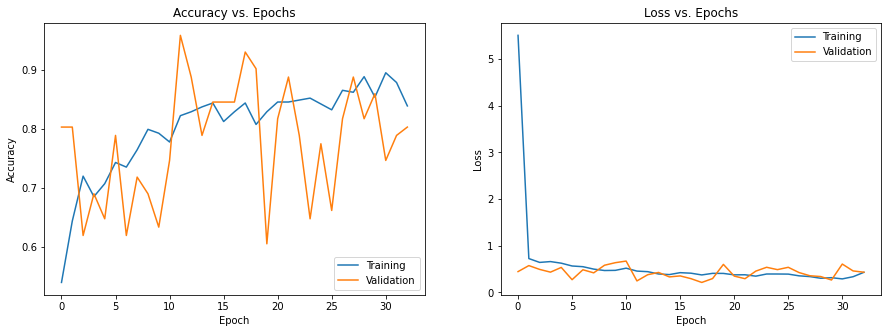

In [40]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### load model

In [43]:
model = load_model(model_fpath, compile = True)

### get test predictions

In [44]:
results = pd.DataFrame(predict(model=model, images=test_images))

### evaluate test predictions

In [60]:
accuracy_score(y_true=results.truth, y_pred=results.prediction)

0.5925925925925926

In [45]:
f1_score(y_true=results.truth, y_pred=results.prediction, average='weighted')

0.6029694738555498

In [46]:
cf_matrix = confusion_matrix(y_true=results.truth, y_pred=results.prediction)

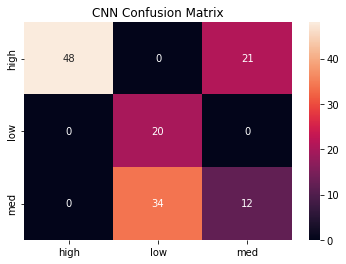

In [47]:
ax = sns.heatmap(cf_matrix, annot=True)
ax.set(
    title='CNN Confusion Matrix',
)
ax.set_xticklabels(['high', 'low', 'med'])
_ = ax.set_yticklabels(['high', 'low', 'med'])

### make final predictions

In [52]:
final_test_images = glob(join('..', 'data', 'original_images', 'final_test', '*.png'))

In [62]:
final_results = pd.DataFrame(predict(model=model, images=final_test_images))[['prediction', 'id']].sort_values('id')

In [63]:
final_results

,prediction,id
254,high,1
230,high,2
236,low,3
175,med,4
189,low,5
...,...,...
108,low,266
109,high,267
138,low,268
133,high,269


In [58]:
final_results.to_csv(join('..', 'data', 'CNN_final_predictions.csv'), index=False)